In [1]:
import os
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.patches as patches
from torchvision.ops import roi_align
from tqdm import tqdm
from torch.autograd import Variable
from torchvision.transforms.functional import crop as tf_crop
from difflib import SequenceMatcher
from torch.utils.data import Dataset, random_split
import torchvision
from torchvision import transforms
import einops

In [2]:
# !python3 -m venv cvproject-env
# !./cvproject-env/bin/pip install ipykernel
# !./cvproject-env/bin/python -m ipykernel install --user --name=cvproject-env --display-name "Python (cvproject-env)"


In [3]:
# !./cvproject-env/bin/pip install kagglehub
# !./cvproject-env/bin/pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !./cvproject-env/bin/pip install matplotlib
# !./cvproject-env/bin/pip install pillow tqdm einops

In [4]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)

/workspace/cvproject-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 18.5G/18.5G [03:11<00:00, 103MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


In [5]:
dataset_path=path+'/CCPD2019/' #To be changed to another path if NOT training


In [6]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# The "O" means "no character".

#For the predicted characters, instead, a different list has to be used with ALL the characters available (The model doesn't
# make distinctions between the three fields of the plate)

all_characters = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "O"]
print("Number of characters:", len(all_characters))

province_to_all_idx = [all_characters.index(char) for char in provinces]
alphabet_to_all_idx = [all_characters.index(char) for char in alphabets]
ads_to_all_idx = [all_characters.index(char) for char in ads]

def decode_sequence(indices, all_characters): #The function needed to return the character sequence from the indices
    return ''.join([all_characters[i] for i in indices if i < len(all_characters)])

Number of characters: 68


In [7]:
class CCPD_Dataset(Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path=os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size
        if self.transform:
            image = self.transform(Image.open(img_path).convert("RGB"))
        else:
            image = Image.open(img_path).convert("RGB")
        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        # Target size after transform
        target_w, target_h = 300, 300

        # Scale bbox coordinates
        x1 = x1 * target_w / orig_w
        x2 = x2 * target_w / orig_w
        y1 = y1 * target_h / orig_h
        y2 = y2 * target_h / orig_h

        # Now turn the characters field into a tensor of indices (integers)
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx[idx])
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx
        
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        charas = torch.tensor([charaslistdef], dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "charas": charas
        }
        return image, target

In [8]:
# Check if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

Using device: cuda


In [9]:
def read_split_file(split_file_path):
    with open(split_file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# Paths to split files
split_dir = os.path.join(path, "CCPD2019/splits")  # adjust if needed
train_list = read_split_file(os.path.join(split_dir, "train.txt"))
val_list = read_split_file(os.path.join(split_dir, "val.txt"))
test_list = read_split_file(os.path.join(split_dir, "test.txt"))
# The augmented version
E2E_transform = transforms.Compose([
    transforms.Resize((340, 340)),
    transforms.RandomRotation(degrees=random.randint(0, 15)),
    transforms.CenterCrop((300, 300)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# The base version
no_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# This selects one of the two transformations at random for each image.
class RandomTransformSelector:
    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, img):
        transform = random.choice(self.transforms_list)
        return transform(img)

random_transform = RandomTransformSelector([E2E_transform, no_transform])
train_dataset = CCPD_Dataset(dataset_path, train_list, transform=random_transform)
val_dataset = CCPD_Dataset(dataset_path, val_list, transform=no_transform)
test_dataset = CCPD_Dataset(dataset_path, test_list, transform=no_transform)

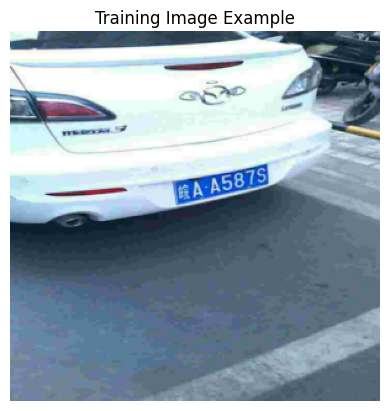

In [10]:
# Train dataset example
image, target = train_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize
image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Training Image Example")
plt.show()

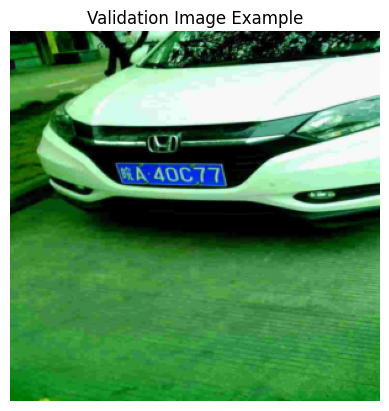

In [11]:
# Train dataset example
image, target = val_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize
image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Validation Image Example")
plt.show()

In [12]:
def collate_dicttargets(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

In [13]:
class FastRCNN(nn.Module):
  def __init__(self, num_classes=2,num_anchors=9):
    super(FastRCNN, self).__init__()
    self.num_classes=num_classes
    model_base = torchvision.models.resnet34(pretrained=True)
    self.base=nn.Sequential(*(list(model_base.children())[:-2]))
    self.shared_conv = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU(inplace=True)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(256, 256)
    self.dropout = nn.Dropout(0.5)
    self.classifier = nn.Linear(256, num_classes)
    self.bbox_pred = nn.Linear(256, num_classes * 4)

  def forward(self, x,proposals):
    features = self.base(x)
    features2 = self.shared_conv(features)
    shared_features = self.relu(features2)

    features_pooled=roi_align(shared_features, proposals, output_size=(7, 7),
                           spatial_scale=1.0 / 32.0, sampling_ratio=2, aligned=True)
    x = self.avgpool(features_pooled)
    x = torch.flatten(x,1)
    x = self.fc(x)
    x = self.dropout(x)
    x=  self.relu(x)
    class_logits = self.classifier(x)
    bbox_pred = self.bbox_pred(x)
    output = {
        "class_logits": class_logits,
        "bbox_pred": bbox_pred,
        "boxes": proposals
    }

    if not self.training:
        probs = torch.softmax(class_logits, dim=-1)
        scores, labels = probs.max(dim=-1)
        output["scores"] = scores
        output["labels"] = labels

    return output

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline2 = FastRCNN(num_classes=2).to(device)

#print(baseline2)
print(device)

/workspace/cvproject-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/cvproject-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 185MB/s] 


cuda


In [15]:
def FastRCNN_losses(preds,targets):
  CEL=nn.CrossEntropyLoss()
  L1=nn.SmoothL1Loss()
  labels=torch.cat([target['labels'] for target in targets])
  bbox=torch.cat([target['boxes'] for target in targets])
  class_logits=preds["class_logits"]
  bbox_pred=preds["bbox_pred"]

  class_loss=CEL(class_logits,labels)
  N=bbox_pred.size(0)
  num_classes=2
  bbox_pred = bbox_pred.view(N, num_classes, 4)
  bbox_pred = bbox_pred[torch.arange(N), labels]
  L1 = nn.SmoothL1Loss()
  bbox_loss = L1(bbox_pred, bbox)
  return {
        "Class_loss": class_loss,
        "bbox_loss": bbox_loss
    }


In [16]:
# The CNN feature extractor for the character recognition task
#cnnbackbone = torchvision.models.mobilenet_v3_large(weights='DEFAULT', progress=True)
#print(cnnbackbone)

In [17]:
batch_size = 10
num_epochs = 3
learning_rate = 0.01
optimizer = torch.optim.Adam(baseline2.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dicttargets, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dicttargets)

In [18]:
for epoch in range(num_epochs):
    baseline2.train()
    running_loss = 0.0

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        proposals = [t["boxes"] for t in targets]  # Use GT boxes as proposals for now

        optimizer.zero_grad()
        images_tensor = torch.stack(images, dim=0)  # Shape: [B, C, H, W]
        predictions = baseline2(images_tensor, proposals)
        loss_dict = FastRCNN_losses(predictions, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Batch 0/10000, Loss: 136.9896
Epoch 1, Batch 10/10000, Loss: 65.6794
Epoch 1, Batch 20/10000, Loss: 31.7969
Epoch 1, Batch 30/10000, Loss: 39.7829
Epoch 1, Batch 40/10000, Loss: 48.1796
Epoch 1, Batch 50/10000, Loss: 54.5549
Epoch 1, Batch 60/10000, Loss: 35.7946
Epoch 1, Batch 70/10000, Loss: 43.1570
Epoch 1, Batch 80/10000, Loss: 46.0157
Epoch 1, Batch 90/10000, Loss: 31.5970
Epoch 1, Batch 100/10000, Loss: 35.4665
Epoch 1, Batch 110/10000, Loss: 21.8035
Epoch 1, Batch 120/10000, Loss: 32.3540
Epoch 1, Batch 130/10000, Loss: 27.0662
Epoch 1, Batch 140/10000, Loss: 49.1815
Epoch 1, Batch 150/10000, Loss: 33.9282
Epoch 1, Batch 160/10000, Loss: 36.8808
Epoch 1, Batch 170/10000, Loss: 35.1086
Epoch 1, Batch 180/10000, Loss: 33.5855
Epoch 1, Batch 190/10000, Loss: 28.5049
Epoch 1, Batch 200/10000, Loss: 22.4198
Epoch 1, Batch 210/10000, Loss: 35.3947
Epoch 1, Batch 220/10000, Loss: 28.9764
Epoch 1, Batch 230/10000, Loss: 25.7147
Epoch 1, Batch 240/10000, Loss: 44.5967
Epoch 1, B

In [19]:
torch.save(baseline2.state_dict(), "fast_rcnn_weights.pth")

In [20]:
def show_bounding_box(image, boxes, scores=None, top_k=None):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5).clip(0, 1)
    plt.imshow(image)
    
    cmap = plt.colormaps.get_cmap('plasma')
    
    #Colormap for confidence scores
    if scores is not None:
        if top_k is not None:
            indices = np.argsort(scores)[-top_k:]
            boxes = boxes[indices]
            scores = scores[indices]
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)  # Normalize to [0,1]
        colors = cmap(norm_scores)
        
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        color = colors[i][:3] if scores is not None else 'red'
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2))

    if scores is not None and len(scores) > 0:
        norm = mpl.colors.Normalize(vmin=scores.min(), vmax=scores.max())
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
        cbar.set_label('Confidence Score') 
           
    plt.suptitle(f'Predicted Bounding Boxes (Showing best {len(boxes)} boxes)')   
    plt.axis('off')
    plt.show()

In [21]:
baseline2.eval()
val_loss = 0.0

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(val_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        proposals = [t["boxes"] for t in targets]  # Using ground-truth boxes as proposals

        images_tensor = torch.stack(images, dim=0)  # Shape: [B, C, H, W]
        predictions = baseline2(images_tensor, proposals)
        loss_dict = FastRCNN_losses(predictions, targets)
        loss = sum(loss for loss in loss_dict.values())
        val_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"[Val] Batch {batch_idx}/{len(val_loader)}, Loss: {loss.item():.4f}")

avg_val_loss = val_loss / len(val_loader)
print(f"✅ Average Validation Loss: {avg_val_loss:.4f}")



[Val] Batch 0/10000, Loss: 5.5273
[Val] Batch 10/10000, Loss: 6.2174
[Val] Batch 20/10000, Loss: 5.6261
[Val] Batch 30/10000, Loss: 3.5257
[Val] Batch 40/10000, Loss: 3.1565
[Val] Batch 50/10000, Loss: 3.2092
[Val] Batch 60/10000, Loss: 6.8506
[Val] Batch 70/10000, Loss: 3.1873
[Val] Batch 80/10000, Loss: 5.1734
[Val] Batch 90/10000, Loss: 5.7845
[Val] Batch 100/10000, Loss: 3.3764
[Val] Batch 110/10000, Loss: 4.9291
[Val] Batch 120/10000, Loss: 3.7151
[Val] Batch 130/10000, Loss: 3.0662
[Val] Batch 140/10000, Loss: 5.2525
[Val] Batch 150/10000, Loss: 3.1620
[Val] Batch 160/10000, Loss: 5.9753
[Val] Batch 170/10000, Loss: 2.8144
[Val] Batch 180/10000, Loss: 6.2405
[Val] Batch 190/10000, Loss: 3.1252
[Val] Batch 200/10000, Loss: 5.5175
[Val] Batch 210/10000, Loss: 4.3220
[Val] Batch 220/10000, Loss: 3.3532
[Val] Batch 230/10000, Loss: 5.3093
[Val] Batch 240/10000, Loss: 4.2862
[Val] Batch 250/10000, Loss: 7.3043
[Val] Batch 260/10000, Loss: 5.8968
[Val] Batch 270/10000, Loss: 5.7193
[Va

Predicted classes: [1]
Predicted bounding boxes: [[ 1.7202616e-01  9.6171236e-01  3.1718761e-03 -3.6931133e-01]
 [ 9.7281082e+01  8.4700523e+01  1.8572476e+02  1.0363342e+02]]


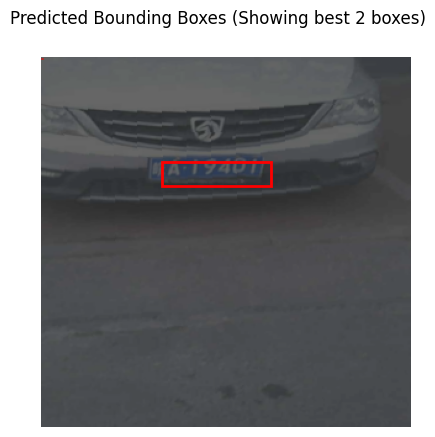

In [22]:
baseline2.eval()
with torch.no_grad():
    image, target = train_dataset[random.randint(0, len(train_dataset)-1)]
    image = image.unsqueeze(0).to(device)
    proposals = target["boxes"].to(device).unsqueeze(0)  # Use GT box as proposal for this test

    # Run the model
    outputs = baseline2(image[0].unsqueeze(0), [proposals[0]])


    # Get predicted class and bbox
    class_logits = outputs["class_logits"]
    bbox_pred = outputs["bbox_pred"]

    # Get predicted class (excluding background if present)
    pred_class = class_logits.argmax(dim=1).cpu().numpy()
    pred_boxes = bbox_pred.cpu().numpy().reshape(-1, 4)

    print("Predicted classes:", pred_class)
    print("Predicted bounding boxes:", pred_boxes)

    # Optionally, show the first predicted box on the image
    show_bounding_box(image[0], pred_boxes, scores=None, top_k=None)

In [23]:
class PlateRecognitionModel(nn.Module):
    def __init__(self, num_classes=len(all_characters)):
        super(PlateRecognitionModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # [B, 64, H, W]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [B, 64, H/2, W/2]
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [B, 128, H/2, W/2]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [B, 128, H/4, W/4]
        )

        self.rnn = nn.LSTM(input_size=128*8, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)

        self.fc = nn.Linear(256 * 2, num_classes + 1)  # +1 for CTC blank

    def forward(self, x):  # x: [B, 3, 32, 128] (or similar)
        x = self.cnn(x)  # [B, C, H, W]
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2)  # [B, W, C, H]
        x = x.contiguous().view(b, w, -1)  # [B, W, C*H]

        x, _ = self.rnn(x)  # [B, W, 512]
        x = self.fc(x)  # [B, W, num_classes + 1]
        x = x.permute(1, 0, 2)  # for CTC Loss: [W, B, C]
        return x

In [24]:
def extract_plate_regions(images, detections, output_size=(32, 128)):
    cropped_plates = []

    for i, img in enumerate(images):
        box_tensor = detections["boxes"][i]  # shape: [1, 4]
        box = box_tensor[0].detach().cpu().numpy().astype(int)  # Extract single box
        x1, y1, x2, y2 = box

        # Clamp to image boundaries
        _, h, w = img.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        # Crop and resize
        cropped = transforms.functional.crop(img.cpu(), y1, x1, y2 - y1, x2 - x1)
        cropped = transforms.Resize(output_size)(cropped)
        cropped_plates.append(cropped)

    return torch.stack(cropped_plates)  # [B, 3, H, W]

In [25]:
ctc_loss_fn = nn.CTCLoss(blank=len(all_characters), zero_infinity=True)


In [26]:
recognition_model = PlateRecognitionModel().to(device)
recognition_optimizer = torch.optim.Adam(recognition_model.parameters(), lr=0.001)

for epoch in range(3):  # Recognition training epochs
    baseline2.eval()  # Detector in eval mode
    recognition_model.train()
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        proposals = [t["boxes"] for t in targets]

        with torch.no_grad():  # Don't train detector
            images_tensor = torch.stack(images, dim=0)
            detections = baseline2(images_tensor, proposals)
        # Step 1: Extract cropped plates
        plate_images = extract_plate_regions(images_tensor, detections).to(device)  # [B, 3, 32, 128]

        # Step 2: Prepare targets for recognition
        text_targets = torch.cat([t["charas"] for t in targets])  # [B, 7]
        input_lengths = torch.full(size=(plate_images.size(0),), fill_value=plate_images.size(-1) // 4, dtype=torch.long).to(device)
        target_lengths = torch.full(size=(plate_images.size(0),), fill_value=7, dtype=torch.long).to(device)

        # Step 3: Forward pass
        preds = recognition_model(plate_images)  # [T, B, C]
        loss = ctc_loss_fn(preds, text_targets.view(-1), input_lengths, target_lengths)

        # Step 4: Optimize
        recognition_optimizer.zero_grad()
        loss.backward()
        recognition_optimizer.step()

        if batch_idx % 10 == 0:
            print(f"[Epoch {epoch+1}] Batch {batch_idx}, Recognition Loss: {loss.item():.4f}")

[Epoch 1] Batch 0, Recognition Loss: -3.4598
[Epoch 1] Batch 10, Recognition Loss: 2.1880
[Epoch 1] Batch 20, Recognition Loss: 5.6239
[Epoch 1] Batch 30, Recognition Loss: 4.1483
[Epoch 1] Batch 40, Recognition Loss: 3.7574
[Epoch 1] Batch 50, Recognition Loss: 4.1018
[Epoch 1] Batch 60, Recognition Loss: 3.4720
[Epoch 1] Batch 70, Recognition Loss: 3.2900
[Epoch 1] Batch 80, Recognition Loss: 3.4126
[Epoch 1] Batch 90, Recognition Loss: 3.3430
[Epoch 1] Batch 100, Recognition Loss: 3.3287
[Epoch 1] Batch 110, Recognition Loss: 3.3340
[Epoch 1] Batch 120, Recognition Loss: 3.4544
[Epoch 1] Batch 130, Recognition Loss: 3.2283
[Epoch 1] Batch 140, Recognition Loss: 3.2176
[Epoch 1] Batch 150, Recognition Loss: 3.1402
[Epoch 1] Batch 160, Recognition Loss: 3.2569
[Epoch 1] Batch 170, Recognition Loss: 3.1594
[Epoch 1] Batch 180, Recognition Loss: 3.3448
[Epoch 1] Batch 190, Recognition Loss: 3.1533
[Epoch 1] Batch 200, Recognition Loss: 3.2171
[Epoch 1] Batch 210, Recognition Loss: 3.002

In [27]:
torch.save({
    'model_state_dict': recognition_model.state_dict(),
    'optimizer_state_dict': recognition_optimizer.state_dict(),
    'epoch': epoch,
}, 'recognition_model_checkpoint.pth')

In [28]:
def levenshtein_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

def calculate_metrics(preds, targets, all_characters):
    total_chars = 0
    correct_chars = 0
    total_samples = len(preds)
    exact_matches = 0
    lev_ratios = []

    for pred_seq, target_seq in zip(preds, targets):
        pred_text = decode_sequence(pred_seq, all_characters)
        target_text = decode_sequence(target_seq, all_characters)

        total_chars += len(target_text)
        correct_chars += sum(p == t for p, t in zip(pred_text, target_text))
        if pred_text == target_text:
            exact_matches += 1

        lev_ratios.append(levenshtein_ratio(pred_text, target_text))

    char_accuracy = correct_chars / total_chars
    exact_match_accuracy = exact_matches / total_samples
    avg_levenshtein = sum(lev_ratios) / len(lev_ratios)

    return {
        "char_accuracy": char_accuracy,
        "plate_accuracy": exact_match_accuracy,
        "avg_levenshtein_ratio": avg_levenshtein
    }

In [29]:
def decode_sequence_ctc(indices, all_characters, blank_index=None):
    """
    Decodes a CTC-style sequence, removing duplicates and blanks.
    `blank_index` should be the index of the 'O' character (or any blank token).
    """
    decoded = []
    prev_idx = -1
    for idx in indices:
        if idx != prev_idx and idx != blank_index:
            if idx < len(all_characters):
                decoded.append(all_characters[idx])
        prev_idx = idx
    return ''.join(decoded)

GT: 皖AB12D | Predicted: 皖AB112D


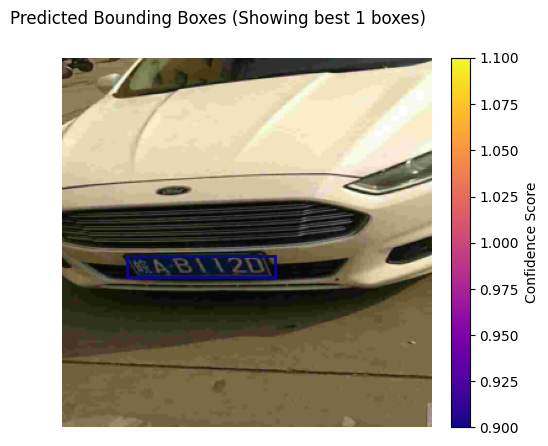

In [ ]:
recognition_model.eval()
all_preds = []
all_targets = []

blank_idx = all_characters.index("O")  # CTC blank index

def decode_sequence_ctc(indices, all_characters, blank_index=None):
    decoded = []
    prev_idx = -1
    for idx in indices:
        if idx != prev_idx and idx != blank_index:
            if idx < len(all_characters):
                decoded.append(all_characters[idx])
        prev_idx = idx
    return ''.join(decoded)

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(val_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        proposals = [t["boxes"] for t in targets]

        # Detector inference
        images_tensor = torch.stack(images)
        detections = baseline2(images_tensor, proposals)

        # Crop and preprocess plates
        plate_images = extract_plate_regions(images_tensor, detections).to(device)

        # Recognition inference
        preds = recognition_model(plate_images)  # [T, B, C]
        pred_indices = preds.argmax(dim=-1).permute(1, 0).tolist()  # [B, T]
        gt_indices = [t["charas"][0].tolist() for t in targets]  # [B, 7]

        all_preds.extend(pred_indices)
        all_targets.extend(gt_indices)

        # 🔽 Visualize first sample in batch
        if batch_idx == 0:
            idx = 0
            image = images_tensor[idx].cpu()
        
            box = detections['boxes'][idx].detach().cpu()
            scores = detections['scores'][idx].detach().cpu()
        
            if box.numel() == 0:
                print("⚠️ No boxes detected for this image.")
            else:
                box = box.numpy()
                scores = scores.numpy()
            
                # Ensure they're at least 1D arrays
                if box.ndim == 1:
                    box = box[None, :]  # Shape [1, 4]
                if np.isscalar(scores) or scores.ndim == 0:
                    scores = np.array([scores])
            
                pred_text = decode_sequence_ctc(pred_indices[idx], all_characters, blank_index=blank_idx)
                gt_text = decode_sequence_ctc(gt_indices[idx], all_characters, blank_index=blank_idx)
            
                print(f"GT: {gt_text} | Predicted: {pred_text}")
                show_bounding_box(image, boxes=box, scores=scores, top_k=1)

# Compute metrics
metrics = calculate_metrics(all_preds, all_targets, all_characters)
print(f"📊 Character Accuracy: {metrics['char_accuracy']:.4f}")
print(f"📊 Plate Accuracy (Exact Match): {metrics['plate_accuracy']:.4f}")
print(f"📊 Avg Levenshtein Ratio: {metrics['avg_levenshtein_ratio']:.4f}")
